In [1]:
import math
import glob
import random

import gym
import numpy as np
from sklearn import metrics, manifold
from matplotlib import pyplot as plt

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2109156725854263476, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6340580945059442543
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4524723306458842477
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1147195006399104690
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

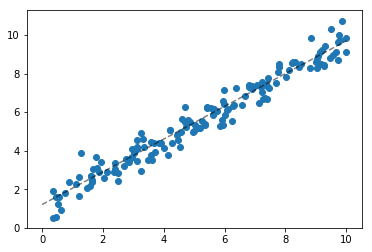

In [5]:
X = np.random.uniform(0, 10, size=(150, 1))
Y = X * .85 + 1.2 + np.random.randn(X.shape[0], X.shape[1]) * .5
plt.scatter(X, Y)
plt.plot([0, 10], [1.2, 10 * .85 + 1.2], 'k--', alpha=.5)

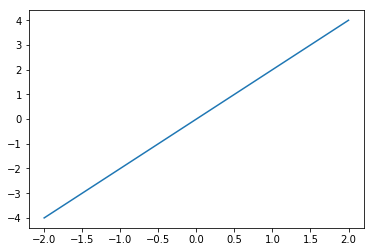

In [6]:
plt.plot(np.arange(-2, 2.1, 1e-1), np.arange(-2, 2.1, 1e-1) * 2)

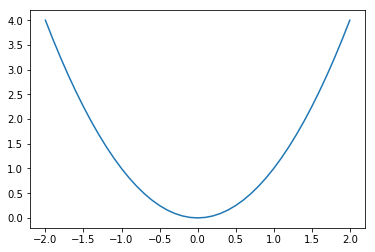

In [7]:
plt.plot(np.arange(-2, 2.1, 1e-1), np.arange(-2, 2.1, 1e-1) ** 2)

# TENSORFLOW

In [8]:
#Ahora, en Tensorflow, para resolver este problema con una red neuronal, le tenemos que decir qué es cada cosa:

X_ = tf.placeholder(tf.float32, shape=[None, 1], name='X_') #Un placeholder es un punto de entrada de datos a tensorflow
Y_ = tf.placeholder(tf.float32, shape=[None, 1], name='Y_')

#w = tf.Variable(np.random.randn(), name="weight")
w = tf.Variable(tf.constant(.4), name="weight", dtype=tf.float32) #La variable w es nuestra variable a (pendiente de la recta)

#b = tf.Variable(np.random.randn(), name="bias")
b = tf.Variable(tf.constant(-2.), name="bias") #La variable b es el sesgo

h = tf.add(tf.multiply(X_, w), b)

# RMSE
error = tf.reduce_mean(tf.pow(h - Y_, 2))

# Optimizer
#lr = .01
#optimizer = tf.train.GradientDescentOptimizer(lr).minimize(error)
lr = .005
optimizer = tf.train.AdamOptimizer(lr).minimize(error) #Vamos a ir variando el learning rate usando el optimizador Adam

# Initializer
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#Ahora abrimos una sesión de Tensorflow (en Tensorflow 2 esto desaparece):

training_epochs = 12
ws, bs = [], []

with tf.Session() as ss:
  ss.run(init)
  for epoch in range(training_epochs):
    indices = [x for x in range(X.size)]
    random.shuffle(indices)
    acc_error = 0.
    for i in indices:
      w_, b_, err, _ = ss.run([w, b, error, optimizer],
                              feed_dict={X_ : X[i].reshape(1, 1),
                                         Y_ : Y[i].reshape(1, 1)})
      acc_error += err
    ws.append(w_)
    bs.append(b_)
    acc_error /= len(indices)
    print('Epoch {}, error: {:.3f}, slope: {:.2f}, bias: {:.2f}'.format(
        epoch, acc_error, w_, b_))

Epoch 0, error: 14.958, slope: 0.92, bias: -1.38
Epoch 1, error: 2.487, slope: 1.12, bias: -1.07
Epoch 2, error: 1.217, slope: 1.15, bias: -0.90
Epoch 3, error: 1.069, slope: 1.16, bias: -0.76
Epoch 4, error: 0.967, slope: 1.14, bias: -0.63
Epoch 5, error: 0.854, slope: 1.11, bias: -0.48
Epoch 6, error: 0.759, slope: 1.08, bias: -0.35
Epoch 7, error: 0.667, slope: 1.05, bias: -0.22
Epoch 8, error: 0.584, slope: 1.05, bias: -0.07
Epoch 9, error: 0.528, slope: 1.02, bias: 0.05
Epoch 10, error: 0.460, slope: 1.01, bias: 0.19
Epoch 11, error: 0.418, slope: 0.98, bias: 0.29


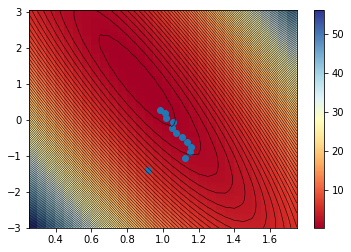

In [10]:
w_values, b_values = np.meshgrid(np.arange(.25, 1.76, .05), np.arange(-3, 3.1, .05))
error_values = np.zeros(w_values.shape)
for i in range(w_values.shape[0]):
  for j in range(w_values.shape[1]):
    error = 0
    for x, y in zip(X, Y):
      error += (y - (x * w_values[i, j] + b_values[i, j])) ** 2
    error_values[i, j] = error / X.shape[0]
plt.contour(w_values, b_values, error_values, 100, linewidths=0.5, colors='k')
plt.pcolormesh(w_values, b_values, error_values, cmap=plt.get_cmap('RdYlBu'))
plt.colorbar()

plt.scatter(ws, bs)

# KERAS

In [11]:
inputs = Input(shape=(1,)) #declaro mi capa input
preds = Dense(1,activation='linear')(inputs) #declaro mi capa densa a la que le meto el input de la primera capa (1 neurona)

model = Model(inputs=inputs,outputs=preds)
sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0) #SGD: Stochastic Gradient Descent
model.compile(optimizer=sgd ,loss='mse',metrics=['mse']) #Le defino mi función de loss
model.fit(X, Y, batch_size=1, epochs=5, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
150/150 [==============================] - 1s 8ms/step - loss: 9.4411 - mean_squared_error: 9.4411
Epoch 2/5
150/150 [==============================] - 0s 2ms/step - loss: 0.3611 - mean_squared_error: 0.3611
Epoch 3/5
150/150 [==============================] - 0s 3ms/step - loss: 0.3431 - mean_squared_error: 0.3431
Epoch 4/5
150/150 [==============================] - 0s 2ms/step - loss: 0.3354 - mean_squared_error: 0.3354
Epoch 5/5
150/150 [==============================] - 0s 2ms/step - loss: 0.3281 - mean_squared_error: 0.3281


In [0]:
#Mirar: https://keras.io/layers/core/ para más ayuda

In [13]:
#SI vamos jugando con el learning rate y epochs, vemos cómo se va ajustando para hallar el valor de a y b correcto:
model.get_weights()

[array([[0.92659086]], dtype=float32), array([0.54714245], dtype=float32)]

In [0]:
#Como vemos arriba, los valores de a (0.85) y b(1.2) no nos lo halla tan bien

## Para los problemas de clasificación, utilizamos la Cross Entropy (Xentropy)

In [0]:
#La función de cross entropia es la función de loss para un problema de clasificación:
def xentropy(true, pred):
  return -(true * np.log(pred) + (1 - true) * np.log(1 - pred))

In [0]:
y_true, y_pred = np.meshgrid(np.arange(0.1, 1., .01), np.arange(0.1, 1., .01))
error = np.zeros(y_true.shape)

for i in range(y_true.shape[0]):
  for j in range(y_true.shape[1]):
    error[i, j] = xentropy(y_true[i, j], y_pred[i, j])

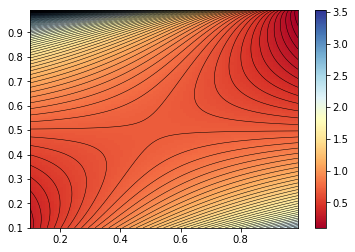

In [17]:
plt.contour(y_true, y_pred, error, 100, linewidths=0.5, colors='k')
plt.pcolormesh(y_true, y_pred, error, cmap=plt.get_cmap('RdYlBu'))
plt.colorbar()

In [0]:
def softmax(x): #Lo que hace la softmax es hacer que la probabilidad de las 3 categorías sume 1 (pero no es probabilidad proporcional si no que da un peso distinto a cada
  #variable)
  return np.exp(x) / np.sum(np.exp(x))

In [19]:
softmax(np.array([3., 1., .5]))

array([0.82140902, 0.11116562, 0.06742536])

In [20]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
input_dim = 784 #28*28 son los píxeles de cada fotografía
X_train = X_train.reshape(60000, input_dim).astype('float32') / 255 #Regularizamos el dataset para que sean valores entre 0 y 1 (esto es muy bueno en las redes neuronales)
X_test = X_test.reshape(10000, input_dim).astype('float32') / 255

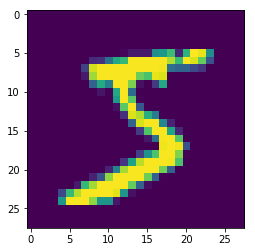

In [22]:
plt.imshow(X_train[0].reshape(28, 28))

In [23]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [0]:
#Si ahora queremos normalizar en one hot encoding las salidas de y:
Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

In [25]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

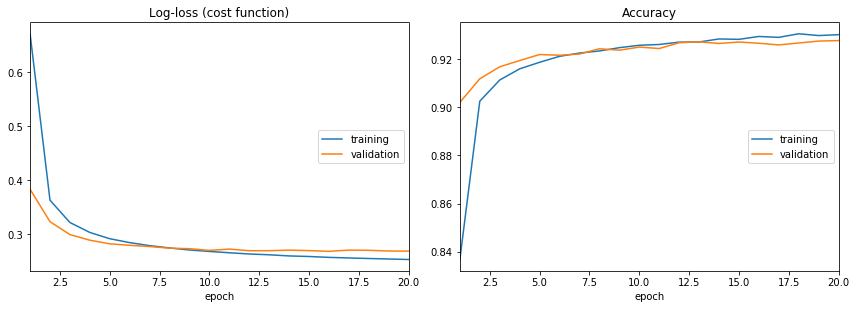

Log-loss (cost function):
training   (min:    0.252, max:    0.671, cur:    0.252)
validation (min:    0.268, max:    0.383, cur:    0.268)

Accuracy:
training   (min:    0.837, max:    0.931, cur:    0.930)
validation (min:    0.902, max:    0.928, cur:    0.928)
Train score: 0.24810633650322755
Train accuracy: 0.9310833333333334
Test score: 0.26797962843477724
Test accuracy: 0.9278


In [26]:
inputs = Input(shape=(784,))
preds = Dense(10, activation='softmax', use_bias=False)(inputs)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.5)
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=0, #el batch size es cuantas muestras le pasas cada vez a la red (cuando metes más muestras en
                   #el entrenamiento, mas facil es calcular el gradiente y más se puede aumentar el learning rate)
                    validation_data=(X_test, Y_test),
                    callbacks=[PlotLossesKeras()]) 
score_train = model.evaluate(X_train, Y_train, verbose=0)
score_test = model.evaluate(X_test, Y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test score:', score_test[0])
print('Test accuracy:', score_test[1])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7840      
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
_________________________________________________________________


In [28]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [29]:
history.history['loss']

[0.671087247021993,
 0.3624085790157318,
 0.32102370982170103,
 0.3025476382891337,
 0.2909859131495158,
 0.2837144060452779,
 0.2781173963228861,
 0.2738762728452683,
 0.2700627667427063,
 0.2673583328485489,
 0.2649391033331553,
 0.26263850096861524,
 0.26118328127861024,
 0.2590415030558904,
 0.2580011682510376,
 0.2563698341290156,
 0.25529810910224915,
 0.2542760788242022,
 0.25335189901192984,
 0.2524087556997935]

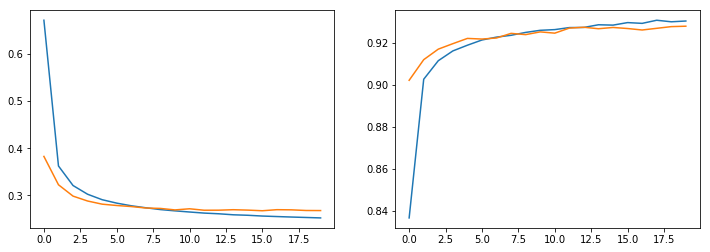

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
ax[0].plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')
ax[1].plot(range(len(history.history['acc'])), history.history['acc'], label='acc')
ax[1].plot(range(len(history.history['val_acc'])), history.history['val_acc'], label='val_acc')

In [31]:
model.get_weights()[0].shape

(784, 10)

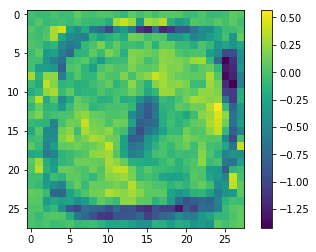

In [32]:
plt.imshow(model.get_weights()[0][:,0].reshape(28, 28))
plt.colorbar()

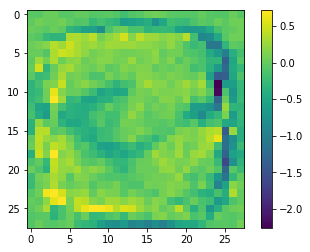

In [33]:
plt.imshow(model.get_weights()[0][:,3].reshape(28, 28))
plt.colorbar()

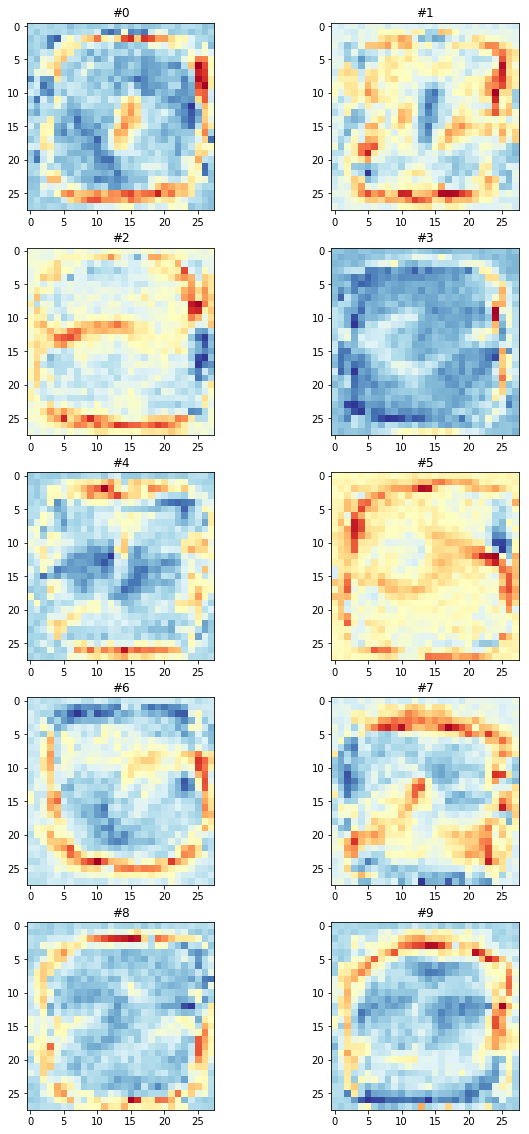

In [34]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, ax in enumerate(axs.reshape(10, 1).squeeze()):
  ax.imshow(model.get_weights()[0][:,i].reshape(28, 28), cmap='RdYlBu')
  ax.set_title('#{}'.format(i))

## Otra red neuronal

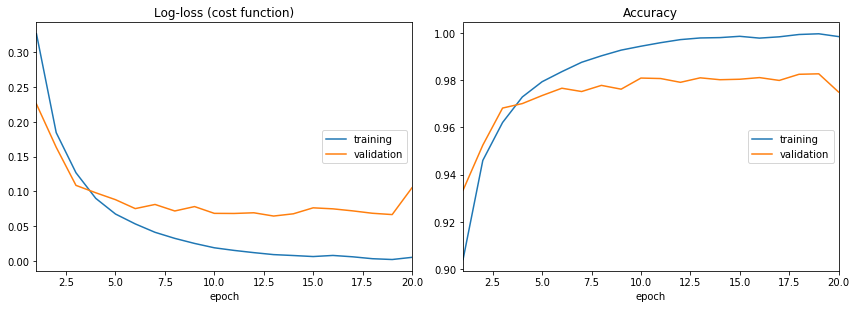

Log-loss (cost function):
training   (min:    0.002, max:    0.327, cur:    0.005)
validation (min:    0.064, max:    0.226, cur:    0.105)

Accuracy:
training   (min:    0.904, max:    1.000, cur:    0.998)
validation (min:    0.933, max:    0.983, cur:    0.975)
Train score: 0.020824644559077083
Train accuracy: 0.9925
Test score: 0.10509163853101126
Test accuracy: 0.975


In [36]:
inputs = Input(shape=(784,))
h0 = Dense(1024, activation='tanh', use_bias=True)(inputs) #Una red con una capa densa de 1024 y metodo Tangente Hiperbólica
preds = Dense(10, activation='softmax', use_bias=False)(h0)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.5)
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=0,
                    validation_data=(X_test, Y_test),
                    callbacks=[PlotLossesKeras()]) 
score_train = model.evaluate(X_train, Y_train, verbose=0)
score_test = model.evaluate(X_test, Y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test score:', score_test[0])
print('Test accuracy:', score_test[1])

Arriba se ve que el modelo hace overfitting. Le hemos metido una capa en medio (h0), que le dice a la capa final (softmax) aún más claramente cuál es el resultado, tanto que al final se ajusta demasiado a la muestra, incurriendo en overfitting.



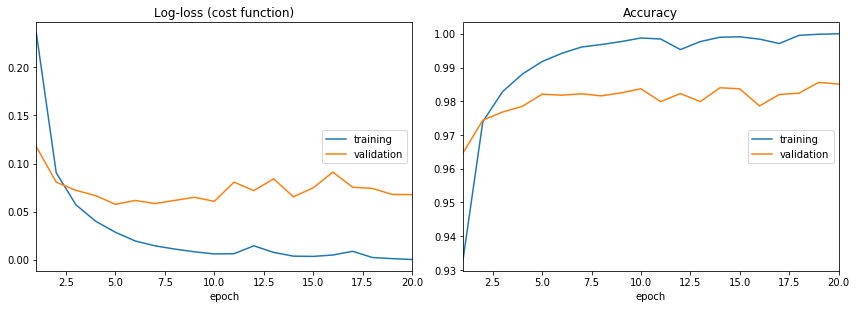

Log-loss (cost function):
training   (min:    0.000, max:    0.235, cur:    0.000)
validation (min:    0.058, max:    0.117, cur:    0.068)

Accuracy:
training   (min:    0.933, max:    1.000, cur:    1.000)
validation (min:    0.965, max:    0.986, cur:    0.985)
Train score: 0.00012656948323656251
Train accuracy: 1.0
Test score: 0.06763401308202478
Test accuracy: 0.9851


In [39]:
inputs = Input(shape=(784,))
h0 = Dense(1024, activation='relu', use_bias=True)(inputs) #Una red con una capa densa de 1024 y metodo Rectifyer Linear Unit
preds = Dense(10, activation='softmax', use_bias=False)(h0)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.5)
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=0,
                    validation_data=(X_test, Y_test),
                    callbacks=[PlotLossesKeras()]) 
score_train = model.evaluate(X_train, Y_train, verbose=0)
score_test = model.evaluate(X_test, Y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test score:', score_test[0])
print('Test accuracy:', score_test[1])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                10240     
Total params: 814,080
Trainable params: 814,080
Non-trainable params: 0
_________________________________________________________________


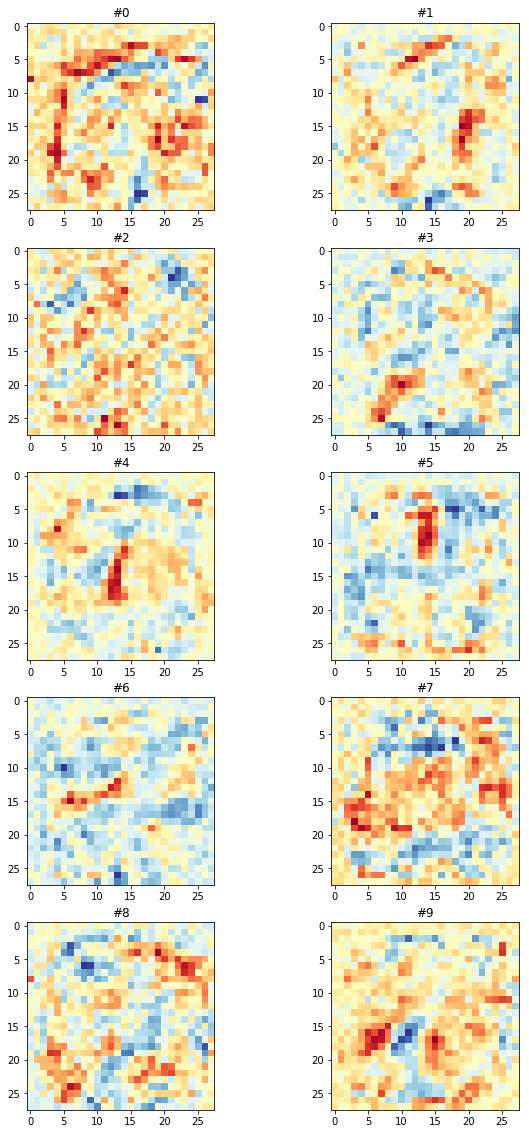

In [41]:
#Veamos qué resultados han aprendido estas capas intermedias:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, ax in enumerate(axs.reshape(10, 1).squeeze()):
  ax.imshow(model.get_weights()[0][:,i].reshape(28, 28), cmap='RdYlBu')
  ax.set_title('#{}'.format(i))

Los resultados que vemos arriba, ya no son tan fácilmente interpretables como cuando visualizábamos lo que la red había aprendido directamente de los píxeles de entrada. Lo que aparece en estos gráficos es lo que la red ha aprendido con esta capa oculta.

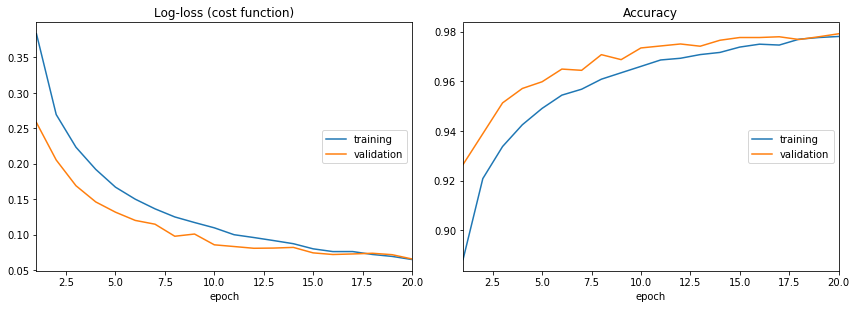

Log-loss (cost function):
training   (min:    0.065, max:    0.383, cur:    0.065)
validation (min:    0.066, max:    0.258, cur:    0.066)

Accuracy:
training   (min:    0.888, max:    0.978, cur:    0.978)
validation (min:    0.926, max:    0.979, cur:    0.979)
Train score: 0.02341138024116711
Train accuracy: 0.99305
Test score: 0.0657770889707841
Test accuracy: 0.9791


In [42]:
inputs = Input(shape=(784,))
h0 = Dense(512, activation='tanh', use_bias=False)(inputs)
h0_drop = keras.layers.Dropout(.5)(h0) #Para evitar overfitting, utilizamos dropout (se eliminan neuronas al azar)
preds = Dense(10, activation='softmax', use_bias=False)(h0_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.5)
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=0,
                    validation_data=(X_test, Y_test),
                    callbacks=[PlotLossesKeras()]) 
score_train = model.evaluate(X_train, Y_train, verbose=0)
score_test = model.evaluate(X_test, Y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test score:', score_test[0])
print('Test accuracy:', score_test[1])

Arriba se ve claramente que el overfitting desaparece con el Dropout de neuronas.

In [43]:
print(model.predict(X_test).shape)
np.argmax(model.predict(X_test), axis=1)

(10000, 10)


array([7, 2, 1, ..., 4, 5, 6])

In [44]:
metrics.confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

array([[ 971,    0,    1,    1,    0,    0,    4,    1,    2,    0],
       [   0, 1123,    3,    2,    0,    1,    2,    1,    3,    0],
       [   5,    1, 1004,    8,    1,    0,    2,    3,    7,    1],
       [   0,    0,    1,  998,    0,    3,    0,    4,    3,    1],
       [   1,    0,    0,    1,  962,    0,    5,    0,    2,   11],
       [   2,    0,    0,    7,    1,  873,    4,    1,    3,    1],
       [   6,    3,    1,    1,    3,    8,  936,    0,    0,    0],
       [   2,    2,    9,    3,    2,    0,    0,  999,    2,    9],
       [   3,    0,    2,    7,    3,    4,    2,    3,  948,    2],
       [   3,    2,    0,   11,    7,    2,    0,    6,    1,  977]])

In [0]:
#Arriba se ve que la red confunde los 7 con los 2, y los 8 con los 3. Pero por lo demas, acierta bastane.

# Redes convolucionales

In [0]:
# Ver https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8

# https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [49]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [50]:
#Red convolucional de imágenes de MNIST (el mismo que antes) sin dropout:

inputs = Input(shape=(28, 28, 1))
c0 = Conv2D(32, kernel_size=8, strides=2, activation='relu')(inputs)
p0 = MaxPool2D(pool_size=(2, 2))(c0)
c1 = Conv2D(64, kernel_size=2, strides=2, activation='relu')(p0)
p1 = MaxPool2D(pool_size=(2, 2))(c1)
#p1_drop = Dropout(0.25)(p1)
f0 = Flatten()(p1)
d0 = Dense(128, activation='relu')(f0)
#d0_drop = Dropout(0.5)(d0)
preds = Dense(10, activation='softmax')(d0)
model = Model(inputs=inputs, outputs=preds)

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
__________

In [0]:
#Como vemos arriba, gracias a las convoluciones, se reducen mucho los parámetros, y se aprende mucho más.

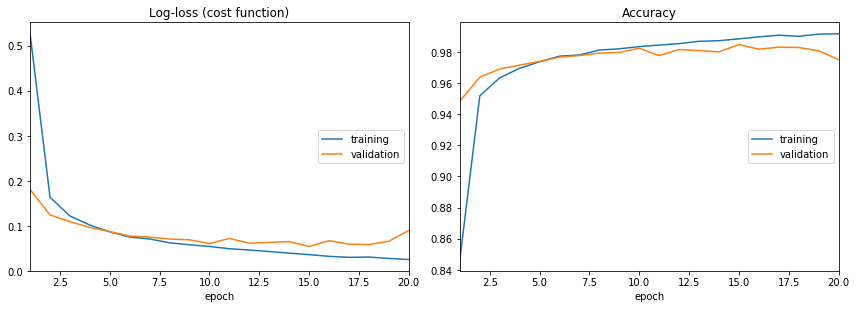

Log-loss (cost function):
training   (min:    0.026, max:    0.526, cur:    0.026)
validation (min:    0.055, max:    0.181, cur:    0.090)

Accuracy:
training   (min:    0.847, max:    0.992, cur:    0.992)
validation (min:    0.948, max:    0.985, cur:    0.975)
Train score: 0.0407358655068092
Train accuracy: 0.986
Test score: 0.09013337032359559
Test accuracy: 0.975


In [52]:
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=0,
                    validation_data=(X_test, Y_test),
                    callbacks=[PlotLossesKeras()]) 
score_train = model.evaluate(X_train, Y_train, verbose=0)
score_test = model.evaluate(X_test, Y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test score:', score_test[0])
print('Test accuracy:', score_test[1])

In [54]:
#Vamos a mostrar los filtros de convolución:

[x.shape for x in model.get_weights()]

[(8, 8, 1, 32),
 (32,),
 (2, 2, 32, 64),
 (64,),
 (64, 128),
 (128,),
 (128, 10),
 (10,)]

In [56]:
model.get_weights()[0].shape

(8, 8, 1, 32)

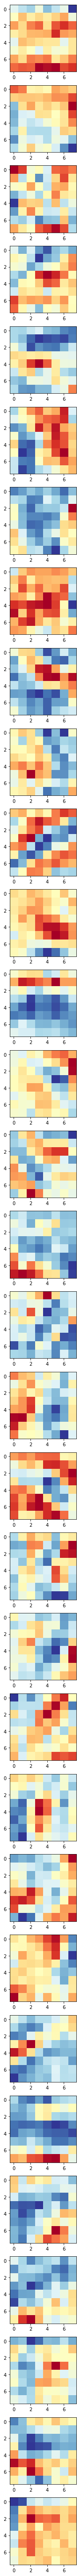

In [57]:
#Estos son los filtros que ha aprendido la primera capa:

fig, axis = plt.subplots(32, 1, figsize=(10, 100))
for i, ax in zip(range(32), axis):
  f = model.get_weights()[0][:,:,0,i]
  ax.imshow(f, cmap='RdYlBu')

In [0]:
# Ver tipos de arquitectura de redes: https://towardsdatascience.com/neural-network-architectures-156e5bad51ba

Keras viene con algunas redes ya preentrenadas, con sus propios pesos.

In [58]:
#Modelo de VGG16 de Keras  para un buscador de imágenes de barcos:

model = VGG16()
model.layers.pop() #haciendo el pop, le quito la ultima capa y me quedo con la penúltima, que acumula el conocimiento que ha adquirido la red
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

553467904/553467096 [==============================] - 6s 0us/step


In [59]:
#Buscamos imágenes de barcos distintos, y de jirafas:

!wget -q -O boat0.jpg https://www.google.com/url?sa=i&source=imgres&cd=&cad=rja&uact=8&ved=2ahUKEwi__Jnk6szhAhUJ1RoKHZYqCgcQjRx6BAgBEAU&url=http%3A%2F%2Fwww.ibizabestcharter.com%2Fes%2Falquiler-de-barcos-en-ibiza%2Fmarina-ibiza%2Fyate%2F116%2Fleopard-32%2Fornella&psig=AOvVaw2mj0UnkOnzvSrnTOqQf5MX&ust=1555236822490705
!wget -q -O boat1.jpg http://gondan.com/wp-content/uploads/2013/10/sea-cloud-II.jpg
!wget -q -O boat2.jpg https://cdn.cnn.com/cnnnext/dam/assets/121008114222-tres-hombres-2-horizontal-large-gallery.jpg
!wget -q -O boat3.jpg https://okdiario.com/img/2018/08/17/barcos-655x368.jpg 
!wget -q -O boat4.jpg https://trabajarporelmundo.org/wp-content/uploads/2016/06/trabajar-en-crucero-de-MSC.jpg
!wget -q -O boat5.jpg https://www.astillerosamado.com/images/barcos/barco-pesca-20m.jpg 
!wget -q -O boat6.jpg https://fotos00.lne.es/2018/03/21/328x206/barco-escuela-atyla.jpg
!wget -q -O boat7.jpg https://newimages.yachtworld.com/resize/1/upload/WCoastOffshoreWest04-08.jpg?w=2048&h=940
!wget -q -O boat8.jpg https://www.lavanguardia.com/r/GODO/LV/p5/WebSite/2018/09/23/Recortada/20180325-636575858917791066_20180325144813-162-kTsH-U4519901328671XD-992x558@LaVanguardia-Web.jpg
!wget -q -O jira0.jpg https://cumbrepuebloscop20.org/wp-content/uploads/2018/09/jirafa.jpg
!wget -q -O jira1.jpg data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSEhIVFRUVFRUVFRUVFRYWFRYVFRUWFhUVFRUYHSggGBolHRUVITIhJikrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGi0lICUtLS8tLS0tLS0tLS0tLS0tLS0vLS0tLS0tLS0vLS0tLi0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAADBAUGAAECBwj/xAA9EAACAQIEBAQEBAUCBQUAAAABAhEAAwQSITEFBkFREyJhcTJCgZEHUqGxFCNywfCC0SQzU2KiFSVzkrL/xAAZAQACAwEAAAAAAAAAAAAAAAABAgADBAX/xAAsEQACAgICAAUDBAIDAAAAAAAAAQIRAxIhMQQiQVFhEzJxgZHR8bHwBSOh/9oADAMBAAIRAxEAPwCbVaIq1oURa1qzM6NhaIqVpRRkFPyDgxVoyitKKMq0CGlWiBa6VaIEoMIMLXYWiKtdhKBAYSjYYax3rapXV20QrR8WUx7xpQYUV+9zhYFxkAnKzKTIGq7x/nUd6sOEuh1DDY99x6H1ryThg+NLircBJJVh5wwPnhtwYJ+/pr6XynbUWyqksNIJ66QTH2rDDxO09aN+Tw2sNkyZVa5vuqKzsYVQWJ6AASTR1qH5yE4HE/8AxMftBir2Zoq2VuzzZdv3ptCLG6mNWURJ+/T6e9twlzxEDRrJBA7gx/nvXj3D+IFVAn4AQI00zZgunTTv81ercsYo3bZY9ln3gz+wrLizylPVmzP4eMYbIca0KG1qnWShsK1mGhIpWslMslclaJBfJWslHy1opSjISvW6Dkp+4tBNurIvgql2KslCy06UrhrdMgMUy0NxTjW+tBuLTJAb4E3oLJTbW6G6VakVt32KZayKMVrV23TP2F5fJgrK4JrdJoxrO1FFRa2qUZEoJjNGItHRK2iUxbSoSjlEoq267RKOqUAg1Skr3FLaXDaIYkAFmABUSJAOs7QdutSoWqiEZr9xh1vXAe8Kco19lFZ8+RwjaLsMFN8lqtEMAykEHqKKFquK1y202j/UrCVPuP71YOF49LpiMrjdDv7qfmFV4vFRnw+x8vhnDldBgtd5KaC+ldBNZq7Yq1PGOPWPCxl+3l0zltTAhtdD00JGvQ1eORywZl+UoCDt5p1gdBA/Sq7z8VXHEkB9UXLB18iaaa96nOBEW2OQZSNQpcwNJIk9PMJ99K5Enplv2Z2YrfFXui6RUFzzf8Ph+JY/9PL7l2CR/wCVT2Huq4DKZB+49D2Nee/ijxlXKYG2wkN4l7SfhXyWgO5LBj2gd9OhOaULOdig3NIonCsErtBbYAlT08wM9zB7+or2XlW1Fj3I6R8o6dO30rzDhlrw7i3PD+IAEjWJ3lTqADvH6V6lyo7G0VdcrLECI8usGPt+lYcD/wCxG/xCf02SRFBuU6yVH8UxSWlz3DAH1JPQKOprpWlyzltN9HEVDcQ48iEi2viEbkGF+hgyf0qOx2Ou3x/07X5AdW/rbr7be9KgeUQPT9R1+hrDl8bbqH7mzH4Slcy14S+LiLcXZgDB3HcH1BkUfJUfywv/AA49HuD/AMif71K5a3Qe0UzHJayaAMlCKU4Urk26ZCsTNutG1TeSt+HTWCrETYoZs1Im3Q2t0LZKRGvh+tKXrJqYZKVurTRm0CUEyMWzG9DxKmnrooLkU27uxdOKI+K1R8tZVn1CvRhkFMItCtimrQoDBLaUxbStW1pm2tBsJiJRlSsUUQCkbDRoLVcw9qLl1ToRdcz0hnzD9D+tWcCq/wAYtm3ezDa4AddsyeU/pk/WqM6tF+F0yA54N+0nj2D5gIYbjYCarnKvNd2/dTMkMrAs35e8H20j1qx84cSuYe0bqLnQ6lD22I1qncr8Ts3bhZWS3mPwZQxB6gE6R/vXO1pttHQ2tVZ7Vy9xQYi2SRDoQr+sqCGHoZ+4NScx7daovAL5s3ww1S4cpgaaf5NXbiCRauEEfA8H1ymK248ilGzHkg4yo8nxPEP+Na86oxIa4VuRlWWCoTPYADprtVis4hLgm2VZnBM6qFUyAAQDlYa/aqjdwavcvK9xUBcZp1bwrflgdgWDGrPYvKAuRCYhRJMR83fQAduvvXOycs6ePhA8WbyoDaxLC6vl8SQq3FHyN3MEHN32jWqdgWe07MzKWZ805lYHNOaXBMEyDv8AWrjxK9b8qO6qTJRSkMQsHSfiA3zba0DFcGtshY5GJAjISdAdpgdT9j9akX5dWRp3aEzjEMADLpCvuQCY8pO5mNfaKuPKPEzeFstPiKDbuDvtBPqDVYxuBFy3rKEEDK6ZQRJGTMmk9mHepvgapbC3LbFm8pn5WAIzSPzQG0jftUi9XYJLaNF0usFBJMAAknsBua8l5w4tfdTetp4nm8qDdUAMEA7mDrGtei8w4vMDbSPlzHpvIX+9eRc5Y60pyw7ZYEJcCroBqRmE/rWjNl2loujNhxax3fYhyzxDF4u7DFltj4pH++s+lX5IWATpso6d9e9Ufkrid3ENktoEtqIkA5iRoczHrV8xIGiIJbRV7lzAAHuao083VF23Hdli5Zt/8ODEZnuMPbMVH/5qUK1rC4YW7aWwfgVVnvA1P1Ov1ouWunBaxSOZJ3JsCRXOWj5a1lpxKA5azJRstaioGgBSuGWmCKGwogYo6UpeWpBxSl0UUwMj7i0pdFPXaUvCaexWhasrqKylHGbYpq3S1umrdWlIzbFMoKBaFMrQYTtRRVrhRRBSDGxS3EsF4tsroGBzIT0Yd/Q6g+9NCt0r5GTopOKs50NphDAwwbWDEQR2/TavK8Zw65hr5S5YyLmlWtAm0xMbzOQ6baV9AY/h1u98Uq0QHXceh6MPQ1CYrg15NSq3IkZlEyvZkPQ9tR61lnjNMMhUOF8UlFyjNA+AHXOsOjT0jzDpuPSrJ/HXsTbe6TksoCvnOW2X3YZjuCYXTYZhUTwjgA8YLORRLuB5Whug9SdNdhO+gqR5psBViyJQCBaLOIE6gIWBC/8Ack6ToeubTRM0KSk0VXi2Eayi3ZtuhUm4PEHnBDSSZnd3PXepThuKS2otKUSUDZUuEsMxkL5t50GusExrURbup8JXxEtoym3cTNdaQYCXjpcA1BO/Q1H2MttQ+U522DwCE11YDSRpp0ikaL4uzOYMaWurA0AggTqoMxHQHTT1qT4XxjMuqyI1OkwdNzvEfWuOH8FfEobgQDSQSTuNSfUbj6UzwvCqoIKjqNjmGu0dDNB8F0WnwWXAYtHKo8OPKZA0Om57/wCdKNhrxW+EKqFZxog8yXfiViw0IaBr1kzqKHhMMCFIYC7aMMPhzKSQNZ+lEwGMyu7SFGTP5RmMBsro20rmg7z2oOhGmD5uW8qeKoldPGtqQz2yZlgF1KsB7iT0mPH8eXxNwmzbvXifMCNbUSfjMwonvA9a9uuXiiuFV0A8pEkHUqFIAExpIAJIB1IpX/0s3irYMKA2Y3VLAKbix5zl3OusTtO5NWY4c36lE58EVydw58Jh/wCcbQO5W0uW2v8AqiWJnf8AferNy/gCz/xLgwP+SCIJEEeIR0EEge89qd4ZyyiQ94i641AiLS9oTqfU/YVNOK148aTtmTJltUjgGa6FcgVuryg2RXJWt1gqEMy1yRRK0aBADCuGFGYUNqJBd6VvU24pS5RIxG6KTuin7opS6KNiihWsroit0QcBbdNWzSlumrZq4rHLdMpStqmUpWEMKIKGtEFIMdCt1qt0AmV0GNaFbFAYieJYUi4LomIIiYAYwTPvA/WqNxDj2Js3rgW0GtswLZVDgg999JnerlzdwC9jbLW0xBtKAWVLY8zuAYDuTtrsANdydq8Ht4e9g3FwXSXNuXJYr5dSV0EmCNZ+1Z8mNGjDJnofGMRbuoHAyllltzLCJDA69ZDTIiNqqd/AXHxADEwy5gSZ0BBj6DT61cOEZr+Ft3bqCCxh4ylgpIBYDr9gYmmrtm2iqzHVjlEdydN/82rI48mpSVFa5b446XCh8qW2yeGBpBby6k77D1g16Ituw5F2AWIykREn8321+teecYtKuJSJOfVoESACANOus1aOE4ggwwABUArA0XWY1kR7aT6Gq5cFy5XBJ8w3LS4ZmUHOfIJ3n36aLPuPWqnglvYdwLgGUZmzAEETDA5TuB/arhbyu1rMA1stkIOskqwifYnT1p7jXDLd1YBMgBZGuhI0jY6T7aUILYk5aqik8W4veZMlgZgxIjq2ugYn9ehNTn4XvdaWZ7LCHORHll1UagaHQbiqr+Itm5aFq1nyLdzDsIEGGjX29z3qx/h7yHaSzbxL+NZvZnKFLjKckwrZT0YAeUypABjWtmKNdmPK/LwekTXLitges+umvvFbrQZgUVyWohoY3phTdZWutbBqEMWt1ytbqERwRQ3NEagvUCCelLtM3DSl00ULYtdpW7TNyl23okYvWV0RWUQcexq3TVul1QjpR7dXWVUOWjTNulrQOmm9OWrR9qRtBSOwaIKIlla29iNRrSbIs1ZzW65FdxUIjAa3Nc1ugE7RoNeRc38hXXxrGyR4V9s7Zmb+VmYeJkTaSZP12NetVAc1XmU2iJ0lmA3ygqoI9QXB/wBJqvJxGx8d7Uau5MPZ8K0oy2rYAUdFURVU4xct38gt6MYkAg5FMgsdegqzXrRcdfOD943+1Q+H4QMOly6wzNlciSPlmBr/AJpWGd38G3HrXyVvjFgm3n3e04z6RquhI+h29KZ4VxJltguWuZddADG0rPaCDUZgrrXr91WYgXkZRp83xKfsWpjhVxA0KpKrA9S2zE+k5fvVEnZpSrgu/C8SLpUgxmMxoYZNST1G23qKlcLjMvi6/E8j01EjvuCf9VV/gfhOVAUgsdSd5YFDPrr+1S2CwAkMxgqQGGsllYET9EO3UGhjbvgmVKuehHn3gxxC4e4pUFXRvMFYZWBVhBEMfMGA7qO1XjCplRABEKoj2AFRfGvKiMihvDYNlMakKwEyO7AT0LUfgXGFxVvxApXuDGh2I9NQa3xyLbR9mCWJuG66JGuTWzXNXooNVywrqsIoimhWyK5mtzRIZWVhrkmgQ09L3KMxoNyiEBcpW6aYumlbtFCgHpdxR7lBcUSNXyANbrorWUeBN2HFM2zOhFLIaYtUpYh23FMqaUQ0e2aFEsYU0RWoQNESoFnN5Oo+tcUwRpFdC0BR2BqKxW6YuW52oBEaGonYGqNVUua77rjLAUamxfCHpnIJEjqJVR9at01D81XxZs/xPh+I1qRG3lciZPQSBVWf7GW4H50QPD+JG74jSAPDS4i9QGRS2vXVjrXBunE2ri/C0xDGdJ29iBv61UreJ8JptHMLf8y1O7Wb2jWnHdXOWP8AvY1a+GWWF0kDLb8JSpgQQR5Ne4EA+oNc+M3Lhm+UFHlEEvCvAxCXHYCWPhruSTmAn0yk1G37TJioWcpZpOoXLBJk9NQNelSvGMK38SiTMIuRm2Gjak9Inf0FExHBsQMguWxctxPiqykZvlmDoNTVbVFt3yTHLtkEhlkEOhgde/uYJ1qx2QLgFxWIIZg46k+ZVb1GpPvNVngF1LQzLl2gAGJZQR120/brVowGHnMdQLvxI0SnwiVjp5Z/1UMH3EzfaR963ddot+dCnguw8xFwBCn+nyKPedq75PvItxyTlNz4lny5x80bCRGumo9ageXedks4hcO6HKTlzg6FiRmZvXMxpnjmaxfuHLMOWKicrI+uZRsdDBHUilyT0kssX+SzHDeLxSX4f+/oeh3EodVDB8ZfDBHLBsLcJC5muM6MBqskN7jUadNDVpw+Lt3AGturA9j+9dPDnjNHMzYJY/lBaytGsBq8zGNXBrsitMKIDma01aIrDRIcmg3DRGNBc0AgbtK3jTF00peNMhbAXDQi1d3DQTRYUzeasrit0OCt2Gtmj2zSqtRrZo0WWPW2pq2aStGmrZqMA0tESgg0RTSDDAroGuFuV0DQCdKa01oEya2K3NAIM2hG1cHDKysrgFWBBU7EHQg0etrUvglHnOO5CazcdrIzWXtuJGty00Ssr86yBtrtppr3jcHcXALaZlz6BcpBlQc0L+YgDbrFeiqaqfOXLPjg3bZIZTmZZ0iCGK9jsY9D1JnDlwapuBtx59mlMoy2LVi2XuufDKeYzmbwwxyos6ZjIHprUtwbm2xfAFhP+YoADGQzoTo0DyuZPm9u1VHmK6LltkE6Kq6mSQC4k95IY1T+VMRcs4o2NYuSVEx5wMyn6xH1qlY9otr0L3PVpP1PbmteTOtsTEIrZgAzRCnvlgzP9qy9zfh8FlXE3CfHcqBEwCYJBA0Ubfaq1g+LPdZzm8oeyQAjEZnUBlk6AyRr61Ac/cPu4viyWlUxZw9lm/KpYBmJ7bgfShixNO+iZJqq7D8Xw38PfOeIzg5pkMpyNmAPQgk/X0r0LiFl72Dw+JT+YUQo4G7KCFPuQVJj1NQ3EeWWxmDsKCBctwhbf+Vr5zH5T+jVZl4imAs2sMyF1IZQJ8wW2Bmb11I+pquMIuLcuq/ounkdx0Xmv+wBwdpuGut1SyPcEKwgiSoEdiIkH61WeT+IJw+8bN+4xRhmtuS3mXbUGQT3AiPtVt5ixROBzp50BR0aN0BIYN7T+lUnE4azfssjsILZ0YfFbcaZhHTuNNKWU/pSil1SGxw+rCTfds9Xw+IS4MyMGB6iiAVT+SOJXba/w2IAlYylAxBB2M5QCPXX11Bq5Guxiybxs42bFpKjVYa3FYRVhXQMiuGopFCaiAGxoD0dqWuGigeoG4aUummblK3TRQovcoDNRblLuaIyZo3Kygk1lSkHUbSmLRpVDR1NGxK5HbRpu3Ufaamrb1GEeU0RTQEaiqaQYKK7U0INWwaAaDg10DQA1ED0GQIDXQNDVq6JoBCA0rxNSbN0DfwrgH/0NFmup6HY7+1BoKZ8+8WVzfNxUDDVXWQMwzypB+HNDH71vAcLss9q9mZWttOVozIYMLpqwk/rU9zFgihZZAKOV2+xH1g/Soi/dJVWgFwwOmnlB2+xP3rkOTXTOukn2SHL5Cs9vw3LPczD+kDT4iIIgbd/pXo9+CS1u0jXLiJmznLqgIBY9YGw9+9eVpxMowK22f1UnLqRAbNtvtvtvXoOAxJueG2WDBV5UAgwIBUe42/vUlkbVMjxpOyT4TmsrNwqxMTCkak+YAbBYgCD0qmc0cVS/fuXLbSigqCNCBlGVwSNVJT9TU3zRxR8LYe8wJ/mWVgarGcNcCztKK+/UdK81uO63sp8qsc4mRoxzNAGyyTpSybcK+SzDFb7M9Q/Dbiq3bd22w8oUPlgxMRcEdNY07zpUZxvlwAG/gG8S1lJe0hBdOvlB1I0MjcR1pD8L8Sy46/anyskjWBHljTv60tw3iZVzldkZSRm7FZ006SsQR96E5JYopq1z+g0IN5pOLp8fh/7RN8tj+LV7KMFdEzW7kSbbAgRO+Vogiek6EVbuB3rotgX2BP5sjACNCM2oJnuaRwHGFGHuYlbYDKR4qqAM7QAGH9QjQ9agOFcxGSQuZiZyFokkyQCdAd4/eDVuHLDDrz2UZsU823FV/n1PQ5rCaS4TjvHti5lKz0Mafamya6qaatHJknF0zTUJzXbmhMaZCnLGlblGuNS9w0yFsBdNK3KYumlbjUQC9xqVuGjXWpR2phfk5NysoTNWVKH2HFuUZWqPS59qYR6iQrfJI22pu29Rdt6bt3KLAiSVqItykrd2u/GjU7UtDWSCvXP8QsgSCSYiq9j+LbWQ4FxmIBX5QNQWHaKg8HfvpcLglhnaSQARHYbVTOer4V/gm1l0xnFMmcIhZljSQNxPWs4Txdb40BVgYII61XOM3XZfGtq6s4UZcoYNOgntTvAXupE21g/GfmDdQRRe23wBSLUHrYagA11molocNXU0sGrsPUohXeceFZ1N1RJEZhpvEAjqdCRXm72yDH6Ezt6ev8AavaXMiO/pVG5m5SJJuWfUwNx9Ou9c/xOB/dE3eGzpeWRXMBjAoZG1DSdlJBHup7dIqTXioe2PDZxdRrawSIcM6qQRpJiG0jaoG5wzEFguQkmB1OxA169f2q+ct8nqLL5189xYBJIIAkQPyzOvWsmPHLI6Rry5IwVspXO/HBcNrDwHFrzXdTBfLAEgn4VLH3b0qst5iSpIGy5jJCmev8AnxU7zNwR8NdNtpgmVbYNuDJ/MOo+vWp78PuXTfuB7ig2UbUEHzkfKCexAmPWmauki6DjGLk+ia/D7hl/O2IuIERrYXXVmIy5WHUfN76dhUJzFwO9gsS90DPZuOXDDUguSSjDUDUEg+1WHnbnE2HNjDgeIoGZhHlmCAo2JjQ1F8vc8F3FrExqYzx5SN4uKf3HUnsaeUYa6FMXk2+rXfoSPCvNhMabca2M+hEB0lhGumg09KqOHxGU6nWeu/fX969j4Lh7KFwltVzAyANCP7bxHpXnvNfLZw7GPNYdhkeJKkgmD69j1qjLhccaff8AZbg8RGeSS6vr9iS5d5hKMUgHMdlEknT13/er1buyAYInodDXiWCxuV/MTM7iBsQBH3/avX+EYjPYtNmksu/eNK1+ByP7H+hk/wCQxRVTS/I6xrhjWM1CZ66ZymY9K3jRXelbjUUKwNxqTuNRrj0ndanQvqcXGpO7RmaNaWuNRQGczW6WY1ujSJswimmUelLddg61FzwTrkfR6ZR6j7bUyr6UWBcjyPS2PNxmypIUoJIiJnWOxitLdgT0AqI4rxdwB4aEiJzLqR6EDalb15YHzwE4f4KaFs10FlZidQjE6T196Fc4kgZPCQGGB6lSUBU61BWsQXdne1Pzk6lsvYRVmu+EFts2YCMuUaQD10+lUwU8i9l/6FuMQly4b7WAmayMxZl+kggdpqfVQiatqNS3f3qIwoh1zCSgIVvQev1rviHE2RDFot37fQ1c1XYEyVw/FlOb07dfpT9nEqwlTIrz67xOWC2jJU6QZgEeaTVp4KzeGC8ydT2HtWeORSk0v3LU2TguUO/jFVZJA1jUxr6Uje4hbtznYKYJ19KGVFwW3UAyJkiQBvIHerKJsyYs3cyhv2oVy+rKwUjMNIJigYaAARp6Db3oeLgt5llcpMjeRUoLYG7xtbZFuF8SYyyNB+b2qaweIOuYgkHp61WBg7L5bxlFYnpq06CfT0qVwNtVBI3n2paduwJnXMfC7V8B3RXAMlWEwYjMD07VS+YeckwyeBhcudRBgeW3HboW3071fbd6P7j0rzb8SeWspOJtDSPOAJLCQM+nVdj6Qaw+IxavdHS8JlUvJL9CktdNwlm1ZiSTM6kkk0Tg/DWxF5bCnzMfiadANWP2/ao208GY/Q/b969M/DPg2VWxTLq/ltkx8PzGfUyPpWVRt0dHJkSjZM8zcYGFsFA0O4yJJIImAxB32ig8ncZXEI2EvnMrKAkwCCI0HY6yO0b7VQ/xA4qL2KYKTksrk6/ECc3+30pDhOMKSG018pEyDMz9DFCbaey/b4Ex404av15v2ZZebeXWssyxMnPaadGEmGMd9iPX0FT3J/Ev/bRdWZS+NDtOiMvt5jT3B8YMfhzh7p/nIMyOY80GJ09CAf6gaHf4M+Ewl6wnmzJduDTTMWNyB6gCPpNTHCrlHr0+PgXLkuoz7vn5XuWeziQ6hxsf8itNcqmcn8bDHw2OjRl7AkCKtTPXV8NmWWF+vqcjxWB4Z16eh29ylbjVt3pe69aUjK2DuvSeJuhRqQBUfxvEOCMuiATmB69jUA/F7lxypgKoEk7GleSMZa+ovL5LBiMcoBYHMF3jXeo5eLWyuYmNSI6/WozC8WZQQbZKarP+wpX+BV0YqWzj4lbuT0PtRtz4g+fkFtdliXEqdQwg1lK2cHbVQB0Hesqyl7k2fsSaHrWA61lZQiWS6DpRQ1ZWVLAiO45xDwx4YUkup1BAgDqZ96g8RjwhTD2ZUmc7NqHJHwmP3rKyi+7/AAUN8ktgwWB0yr4eYKpA0iCs70zg8pssQIWNFYzvvrW6yrn0IuTvCcUh2RxJnLpEDQEH9aW5hx1yRaPlDMqkqYPfy9j71qsrPNXZcnwa4Jw5AcsFlb4WMA7+YMBvUjjOJtacZCxRR/MGnlA7SdaysqvLFRjxwPB2P2sYl4qcmrJ835fbvT+HuglIkAKQR0kelZWUsJNotaGXeBp0E/bpXC4gMgYhtZIg6xWVlMwEXwz+YbnmItSFCHcEdVPQVModD2nT2rKylh0Q6z0PG2TdtlAQG3RiJAaNJHVTsR2JrKypJJqmMm07R5+3AsNi84yGxdRmS6qQUW4vboRImRv1q0WL9vB4UhcxS1bP9R9e0yaysrkLyydfJ2H5qT+Dx7xZMmddzPfr760MCIO4g6T2M9aysqGnsuv4e4s/xFsCfnGvTytqD9AfqdelXLmHmHw7uGzJFq4suDBZSSYO+sZTMbzWVlRNxg69/wCCqUFPKk/b+So8V4JdwmJPhDNauMMgzAFGb5NY8szH0q9HESxQiGCoxG/xDXX3mt1laMPky8ev8MyZ39TCtvRP/KIfiOPuq2UKNSIM661GcY47kRUYAu0TvGvrWVlb8s3Ho5GvF/JA8Rxfg/ExZDAYa9e1L8R4llUvaEr20BAA9a3WVz3Jxbr3I+as0ZezbYAQdSdmNDvXytssmcKJ1JEyK1WVtx8vl+g6XCC8Ox4FtZYnTcj1NZWVlGOSSSEcFZ//2Q==
!wget -q -O jira2.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQkiHgtn8jEOQL-qvySecSE6_o4k4lnfuU_Ijw3mavI3jfC3R-d
!wget -q -O jira3.jpg http://www.deciam.com/wp-content/uploads/2014/06/gal-jirafa-700x460.jpg
!wget -q -O jira4.jpg https://10radio.es/wp-content/uploads/2017/06/jirafa-con-su-cria.jpg
!wget -q -O jira5.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTgWGrMmitAVO3X59tmgO9bAuD9iSmYwnCCaJL1UdztfEsrWx9cWA
!wget -q -O jira6.jpg https://conceptodefinicion.de/wp-content/uploads/2016/03/Jirafa.jpg
!wget -q -O jira7.jpg https://www.gestacionde.com/wp-content/uploads/2018/01/jirafas.jpg
!wget -q -O jira8.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSAA9PRrXtSyLMGFiWt_p4SujoFMv9dObMH2vpxN4VcDqu3gYAH

/bin/bash: base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSEhIVFRUVFRUVFRUVFRYWFRYVFRUWFhUVFRUYHSggGBolHRUVITIhJikrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGi0lICUtLS8tLS0tLS0tLS0tLS0tLS0vLS0tLS0tLS0vLS0tLi0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAADBAUGAAECBwj/xAA9EAACAQIEBAQEBAUCBQUAAAABAhEAAwQSITEFBkFREyJhcTJCgZEHUqGxFCNywfCC0SQzU2KiFSVzkrL/xAAZAQACAwEAAAAAAAAAAAAAAAABAgADBAX/xAAsEQACAgICAAUDBAIDAAAAAAAAAQIRAxIhMQQiQVFhEzJxgZHR8bHwBSOh/9oADAMBAAIRAxEAPwCbVaIq1oURa1qzM6NhaIqVpRRkFPyDgxVoyitKKMq0CGlWiBa6VaIEoMIMLXYWiKtdhKBAYSjYYax3rapXV20QrR8WUx7xpQYUV+9zhYFxkAnKzKTIGq7x/nUd6sOEuh1DDY99x6H1ryThg+NLircBJJVh5wwPnhtwYJ+/pr6XynbUWyqksNIJ66QTH2rDDxO09aN+Tw2sNkyZVa5vuqKzsYVQWJ6AASTR1qH5yE4HE/8AxMftBir2Zoq2VuzzZdv3ptCLG6mNWURJ+/T6e9twlzxEDRrJBA7gx/nvXj3D+IFVAn4AQI00zZgunTTv81ercsYo3bZY9ln3gz+wrLizylPVmzP4eMYbIca0KG1qnWShsK1mGhIpWslMslclaJBfJWslHy1opSjISvW6Dkp+4tBNurIvgql2KslCy06UrhrdMgMUy0NxTjW+tBuLTJAb4E3oLJTbW6G6VakVt32KZayKMVrV23TP2F5fJgrK4JrdJoxrO1FFRa2qUZEoJj

In [60]:
!ls -lh

total 1.2M
-rw-r--r-- 1 root root 1.4K Apr 13 10:23 boat0.jpg
-rw-r--r-- 1 root root  93K Jan 25  2017 boat1.jpg
-rw-r--r-- 1 root root 151K Apr 13 10:23 boat2.jpg
-rw-r--r-- 1 root root  41K Aug 17  2018 boat3.jpg
-rw-r--r-- 1 root root  43K Jun 30  2016 boat4.jpg
-rw-r--r-- 1 root root 157K Sep 13  2016 boat5.jpg
-rw-r--r-- 1 root root 9.7K Mar 21  2018 boat6.jpg
-rw-r--r-- 1 root root    0 Apr 13 10:23 boat7.jpg
-rw-r--r-- 1 root root  67K Sep 23  2018 boat8.jpg
-rw-r--r-- 1 root root  63K Sep 26  2018 jira0.jpg
-rw-r--r-- 1 root root    0 Apr 13 10:23 jira1.jpg
-rw-r--r-- 1 root root 7.4K Apr  9  2018 jira2.jpg
-rw-r--r-- 1 root root  66K Jul  4  2014 jira3.jpg
-rw-r--r-- 1 root root 237K Jun 12  2017 jira4.jpg
-rw-r--r-- 1 root root  15K Dec 31  2016 jira5.jpg
-rw-r--r-- 1 root root  58K Mar 22  2016 jira6.jpg
-rw-r--r-- 1 root root  73K Jan  9  2018 jira7.jpg
-rw-r--r-- 1 root root  12K Oct 15  2016 jira8.jpg
drwxr-xr-x 1 root root 4.0K Apr  4 20:20 sample_data


In [0]:
#Definimos una función que reescala laimagen al tamaño que necesita nuestra VGG para procesarla:
def rescale(data, width=224, height=224, force=True):
  """Rescale the given image, optionally cropping it to make sure the result image has the specified width and height."""
  from PIL import Image as pil
  max_width = width
  max_height = height

  img = pil.open(data)
  if not force:
    img.thumbnail((max_width, max_height), pil.ANTIALIAS)
  else:
    src_width, src_height = img.size
    src_ratio = float(src_width) / float(src_height)
    dst_width, dst_height = max_width, max_height
    dst_ratio = float(dst_width) / float(dst_height)
    if dst_ratio < src_ratio:
      crop_height = src_height
      crop_width = crop_height * dst_ratio
      x_offset = float(src_width - crop_width) / 2
      y_offset = 0
    else:
      crop_width = src_width
      crop_height = crop_width / dst_ratio
      x_offset = 0
      y_offset = float(src_height - crop_height) / 3
    img = img.crop((x_offset, y_offset, x_offset+int(crop_width), y_offset+int(crop_height)))
    img = img.resize((dst_width, dst_height), pil.ANTIALIAS)
  return preprocess_input(np.array(img, dtype=np.float64))

In [63]:
model.predict(rescale('boat1.jpg').reshape(1, 224, 224, 3), verbose=0)

array([[0.        , 0.76432705, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [66]:
#quitamos algunas fotos que no estaban bien guardadas:
!rm boat0.jpg
!rm boat7.jpg
!rm jira1.jpg

rm: cannot remove 'boat0.jpg': No such file or directory
rm: cannot remove 'boat7.jpg': No such file or directory


In [0]:
#Le pasamos las imagenes ala VGG:

images = []
for name in glob.glob('boat[0-9].jpg'):
  images.append({'type': 'boat', 'name': name, 'vector': model.predict(rescale(name).reshape(1, 224, 224, 3), verbose=0)})
for name in glob.glob('jira[0-9].jpg'):
  images.append({'type': 'jira', 'name': name, 'vector': model.predict(rescale(name).reshape(1, 224, 224, 3), verbose=0)})

In [69]:
# Ahora miramos la similitud  de cada elemento respecto a los demas:

for img_a in images:
  distances = []
  for img_b in images:
    distances.append((img_b['name'], metrics.pairwise.pairwise_distances(img_a['vector'], img_b['vector'], metric='cosine')[0, 0]))
  distances = sorted(distances, key=lambda x: x[1])
  for elem in distances:
    print('FROM {} TO {}: {}'.format(img_a['name'], elem[0], elem[1]))
  print('-' * 50)

FROM boat5.jpg TO boat5.jpg: 0.0
FROM boat5.jpg TO boat3.jpg: 0.24713075160980225
FROM boat5.jpg TO boat8.jpg: 0.3322752118110657
FROM boat5.jpg TO boat4.jpg: 0.3691886067390442
FROM boat5.jpg TO boat1.jpg: 0.40169161558151245
FROM boat5.jpg TO boat2.jpg: 0.4692199230194092
FROM boat5.jpg TO boat6.jpg: 0.5773357152938843
FROM boat5.jpg TO jira4.jpg: 0.821320116519928
FROM boat5.jpg TO jira3.jpg: 0.8396311402320862
FROM boat5.jpg TO jira6.jpg: 0.8415703177452087
FROM boat5.jpg TO jira7.jpg: 0.8445555567741394
FROM boat5.jpg TO jira5.jpg: 0.8499019145965576
FROM boat5.jpg TO jira8.jpg: 0.8726207613945007
FROM boat5.jpg TO jira0.jpg: 0.8868538737297058
--------------------------------------------------
FROM boat1.jpg TO boat1.jpg: 0.0
FROM boat1.jpg TO boat2.jpg: 0.2957215905189514
FROM boat1.jpg TO boat6.jpg: 0.3739027976989746
FROM boat1.jpg TO boat4.jpg: 0.39955729246139526
FROM boat1.jpg TO boat5.jpg: 0.40169161558151245
FROM boat1.jpg TO boat3.jpg: 0.4230697751045227
FROM boat1.jpg T

In [0]:
#Para cada entrada (imagen), nos vamos a construir un array de vectores y, en colores, vamos a clasificar (rojo=barco, jirafa=azul):

X = np.array([i['vector'].squeeze() for i in images])
colors = ['r' if i['type'] == 'boat' else 'b' for i in images]

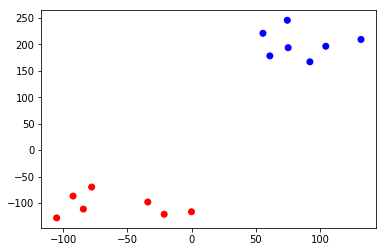

In [71]:
#Con TSNE, vamos a reducir la dimensionalidad a 2 dimensiones, y ver cómo la red ha conseguido reducir el espacio para clasificar:

tsne = manifold.TSNE(perplexity=4, metric='cosine')
X_prime = tsne.fit_transform(X)
plt.scatter(X_prime[:, 0], X_prime[:, 1], c=colors)

In [72]:
#RNN de IMDB:

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=5000)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

17465344/17464789 [==============================] - 0s 0us/step


In [73]:
#Clasificamos las opiniones que hay en IMDB:

inputs = Input(shape=(500,), dtype='int32')
emb = Embedding(input_dim=5000, output_dim=32, input_length=500)(inputs)
l0 = LSTM(units=100)(emb)
preds = Dense(1, activation='sigmoid')(l0)

model = Model(inputs=inputs, outputs=preds)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=256)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 136s 5ms/step - loss: 0.5855 - acc: 0.7044 - val_loss: 0.3878 - val_acc: 0.8335
Epoch 2/3
25000/25000 [==============================] - 135s 5ms/step - loss: 0.3241 - acc: 0.8694 - val_loss: 0.4125 - val_acc: 0.8272
Epoch 3/3
25000/25000 [==============================] - 135s 5ms/step - loss: 0.2742 - acc: 0.8941 - val_loss: 0.3029 - val_acc: 0.8737


In [75]:
inputs = Input(shape=(500,), dtype='int32')
emb = Embedding(input_dim=5000, output_dim=8, input_length=500, embeddings_regularizer=keras.regularizers.l2(0.))(inputs)
c0 = Conv1D(filters=4, kernel_size=4, padding='same', activation='relu')(emb)
p0 = MaxPool1D(pool_size=2)(c0)
f0 = Flatten()(p0)
f0_drop = Dropout(0.5)(f0)
d0 = Dense(8, activation='tanh')(f0_drop)
d0_drop = Dropout(0.5)(d0)
preds = Dense(1, activation='sigmoid')(d0_drop)

model = Model(inputs=inputs, outputs=preds)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 8)            40000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 4)            132       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 4)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 8008      
__________